In [56]:
import tensorflow as tf
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fnxxrsq9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-fnxxrsq9
  Resolved https://github.com/tensorflow/docs to commit c6fe18c88c6078bea4f66226f88570e97e0765c6
  Preparing metadata (setup.py) ... done


In [57]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import math
from IPython import display
import cv2
import os

In [3]:
!unzip /content/dataset2.zip

Archive:  /content/dataset2.zip
  inflating: img/Alef-Bold_65.png    
 extracting: img/Alef-Bold_66.png    
 extracting: img/Alef-Bold_67.png    
  inflating: img/Alef-Bold_68.png    
  inflating: img/Alef-Bold_69.png    
  inflating: img/Alef-Bold_70.png    
 extracting: img/Alef-Bold_71.png    
  inflating: img/Alef-Bold_72.png    
  inflating: img/Alef-Bold_73.png    
  inflating: img/Alef-Bold_74.png    
 extracting: img/Alef-Bold_75.png    
  inflating: img/Alef-Bold_76.png    
 extracting: img/Alef-Bold_77.png    
  inflating: img/Alef-Bold_78.png    
 extracting: img/Alef-Bold_79.png    
  inflating: img/Alef-Bold_80.png    
 extracting: img/Alef-Bold_81.png    
 extracting: img/Alef-Bold_82.png    
 extracting: img/Alef-Bold_83.png    
  inflating: img/Alef-Bold_84.png    
  inflating: img/Alef-Bold_85.png    
 extracting: img/Alef-Bold_86.png    
 extracting: img/Alef-Bold_87.png    
 extracting: img/Alef-Bold_88.png    
  inflating: img/Alef-Bold_89.png    
  inflating: img/A

(1716, 36, 36)
(1716,)
15.0


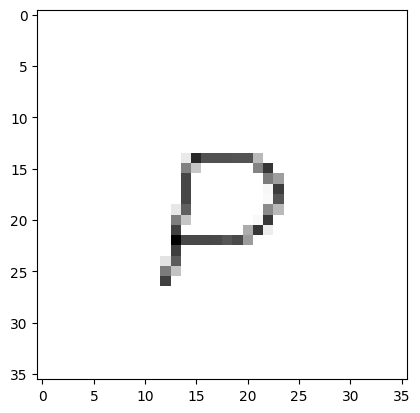

In [58]:
dataset_path = '/content/img'

# Initialize empty lists to store images and labels (if applicable)
images = []
train_labels=np.array([])
# Iterate through the files in the dataset directory
for file_name in os.listdir(dataset_path): #The os.listdir() function returns a list of filenames found in the specified directory.
    if file_name.endswith('.png'):
        # Construct the full path to the image file
        image_path = os.path.join(dataset_path, file_name)#The os.path.join() function is used to construct a full file path by combining the dataset_path (the directory path) with the file_name

        # Load the image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image.astype(np.float32)#The code converts the image data to the float32 data type using NumPy's astype() method

        # Append the image to the list of images
        images.append(image)
        className = tf.strings.split(file_name, '_')[-1]
        className = tf.strings.split(className, '.')[0]
        x=int(className)-65
        train_labels=np.append(train_labels,x)

train_images=np.array(images)
plt.imshow(train_images[520,:,:],cmap='gray')
print(train_images.shape)
print(train_labels.shape)
print(train_labels[520])

In [59]:
batch_size = 8
num_channels = 1
num_classes = 26
image_size = 36
latent_dim = 128
buffer_size=1716

In [60]:
train_images = (train_images - 127.5) / 127.5
train_images = np.reshape(train_images, (-1, 36, 36, 1))
train_labels = keras.utils.to_categorical(train_labels, 26)


dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(buffer_size).batch(batch_size)
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of training labels: {train_labels.shape}")

Shape of training images: (1716, 36, 36, 1)
Shape of training labels: (1716, 26)


In [61]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

154 27


In [62]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((36, 36, discriminator_in_channels)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(9 * 9 * generator_in_channels),
        layers.Reshape((9, 9, generator_in_channels)),
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (5, 5), padding="same", activation='tanh'),
    ],
    name="generator",
)

In [63]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer


    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.



        # Assemble labels discriminating real from fake images.

        # Train the discriminator.
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
            real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
            fake_output_Disc = self.discriminator(fake_image_and_labels)
            real_output_Disc = self.discriminator(real_image_and_labels)
            d_loss = -tf.reduce_mean(tf.math.log(real_output_Disc + 0.0001 ) + tf.math.log(1.- fake_output_Disc + 0.0001))
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))




        # Assemble labels that say "all real images".

        # Train the generator (note that we should not update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            fake_output_Disc = self.discriminator(fake_image_and_labels)
            g_loss = -tf.reduce_mean(tf.math.log(fake_output_Disc + 0.0001)) #due to max log (D(G(z))
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [65]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
)
cond_gan.fit(dataset,epochs= 100)
tf.saved_model.save(cond_gan, '/content/saved_model_dir')

Epoch 1/100
215/215 [==============================] - 9s 20ms/step - g_loss: 0.8337 - d_loss: 1.0988
Epoch 2/100
215/215 [==============================] - 4s 20ms/step - g_loss: 0.7680 - d_loss: 1.2472
Epoch 3/100
215/215 [==============================] - 4s 20ms/step - g_loss: 1.0527 - d_loss: 0.8919
Epoch 4/100
215/215 [==============================] - 4s 19ms/step - g_loss: 1.9950 - d_loss: 0.3693
Epoch 5/100
215/215 [==============================] - 4s 19ms/step - g_loss: 1.4275 - d_loss: 0.8769
Epoch 6/100
215/215 [==============================] - 4s 20ms/step - g_loss: 1.2859 - d_loss: 0.7388
Epoch 7/100
215/215 [==============================] - 4s 20ms/step - g_loss: 1.4953 - d_loss: 0.6280
Epoch 8/100
215/215 [==============================] - 4s 20ms/step - g_loss: 1.5597 - d_loss: 0.6109
Epoch 9/100
215/215 [==============================] - 4s 20ms/step - g_loss: 1.4718 - d_loss: 0.6671
Epoch 10/100
215/215 [==============================] - 4s 20ms/step - g_loss: 1.3

In [69]:
trained_gen = cond_gan.generator
trained_dis = cond_gan.discriminator
trained_gen.save_weights("/content/generator_weights.h5")
trained_dis.save_weights("/content/discriminator_weights.h5")
def generateImage(character, noise):
  noise = tf.cast(noise, tf.float32)
  character=character-1
  test_label = keras.utils.to_categorical([character], num_classes)
  test_label = tf.cast(test_label, tf.float32)
  noise_and_labels = tf.concat([noise, test_label], 1)#axis is 1
  fake = trained_gen.predict(noise_and_labels)
  fake=fake*127.5 + 127.5
  final = fake.astype(np.uint8)
  plt.imshow(final[0,:,:,0],cmap='gray')
  return final[0,:,:,0]

1/1 [==============================] - 0s 19ms/step


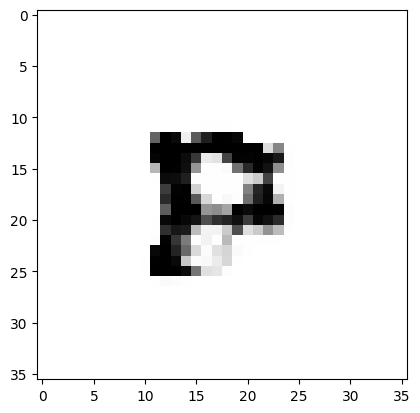

In [72]:
# DO NOT CHANGE THIS BLOCK xxxxxxxxxxx
if __name__=="__main__":
    if False:
        trainModel()
    if True:
        character = 16 # this could be a number between 1-26 corresponding to A-Z
        noise = tf.random.normal([1,128])
        Y = generateImage(character, noise)
        outfile = 'img.jpg'
        cv2.imwrite(outfile, Y)
# DO NOT CHANGE THIS BLOCK xxxxxxxxxxx